In [1]:
import os
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
import secrets
import cv2
from PIL import Image
from PIL import ImageFile
from sklearn.datasets import load_files
from tensorflow.python.keras.utils import np_utils
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.models import Sequential,Model
from tensorflow.python.keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from keras.preprocessing import image                  
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil


from PIL import ImageFile   
from sklearn.model_selection import train_test_split
from keras.preprocessing import image                  
from tqdm import tqdm
from keras import optimizers
from keras.applications.vgg16 import VGG16
import seaborn as sns
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

In [2]:
TEST_DIR = os.path.join(os.getcwd(),"imgs","test")
TRAIN_DIR = os.path.join(os.getcwd(),"imgs","train")
MODEL_PATH = os.path.join(os.getcwd(),"model","vgg16_fine_tuned")
PICKLE_PATH = os.path.join(os.getcwd(),"pickle")
TEST_CSV = os.path.join(os.getcwd(),"csv_files","test.csv")
TRAIN_CSV = os.path.join(os.getcwd(),"csv_files","train.csv")

In [3]:
if not os.path.exists(TEST_DIR):
    print("Testing data does not exists")
if not os.path.exists(TRAIN_DIR):
    print("Training data does not exists")
if not os.path.exists(MODEL_PATH):
    print("Model path does not exists")
    os.makedirs(MODEL_PATH)
    print("Model path created")
else:
    shutil.rmtree(MODEL_PATH)
    os.makedirs(MODEL_PATH)
if not os.path.exists(PICKLE_PATH):
    os.makedirs(PICKLE_PATH)

Model path does not exists
Model path created


In [4]:

gen_per_image = 1
gen_per_class = 200
rotation_range = 5
width_shift_range = 0.02
height_shift_range = 0.02
shear_range = 0.01
zoom_range = 0.05
horizontal_flip = False
fill_mode = "nearest"

In [5]:

height_shift_range = 0.02
shear_range = 0.01
zoom_range = 0.05
horizontal_flip = False
fill_mode = "nearest"

def increase_brightness(img, value):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

def change_contrast(img, level):
    img = Image.fromarray(img.astype('uint8'))
    factor = (259 * (level + 255)) / (255 * (259 - level))
    def contrast(c):
        return 128 + factor * (c - 128)
    return np.array(img.point(contrast))

def pad_img(img):
    h, w = img.shape[:2]
    new_h = int((5 + secrets.randbelow(16)) * h / 100) + h
    new_w = int((5 + secrets.randbelow(16)) * w / 100) + w

    full_sheet = np.ones((new_h, new_w, 3)) * 255

    p_X = secrets.randbelow(new_h - img.shape[0])
    p_Y = secrets.randbelow(new_w - img.shape[1])

    full_sheet[p_X : p_X + img.shape[0], p_Y : p_Y + img.shape[1]] = img

    full_sheet = cv2.resize(full_sheet, (w, h), interpolation = cv2.INTER_AREA)

    return full_sheet.astype(np.uint8)

def preprocess_img(img):
    img = np.array(img)

    x = secrets.randbelow(2)

    if x == 0:
        # img = pad_img(img)
        img = increase_brightness(img, secrets.randbelow(26))
        img = change_contrast(img, secrets.randbelow(51))
    else:
        # img = pad_img(img)
        img = change_contrast(img, secrets.randbelow(51))
        img = increase_brightness(img, secrets.randbelow(26))

    return img


In [6]:
BATCH_SIZE = 128
IMAGE_SIZE = 224
NUM_EPOCHS = 25

In [7]:
#Initialise the parameters for Augmentation.
datagen = ImageDataGenerator(
        rotation_range = rotation_range,
        width_shift_range = width_shift_range,
        height_shift_range = height_shift_range,
        shear_range = shear_range,
        zoom_range = zoom_range,
        horizontal_flip = horizontal_flip,
        fill_mode = fill_mode,
        validation_split = 0.2,
        preprocessing_function = preprocess_img)


train_data = datagen.flow_from_directory(TRAIN_DIR,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=BATCH_SIZE,
                                        subset='training',shuffle=True)

valid_data = datagen.flow_from_directory(TRAIN_DIR,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=BATCH_SIZE,
                                        subset='validation',shuffle=True)

Found 16831 images belonging to 10 classes.
Found 4203 images belonging to 10 classes.


In [8]:
model = VGG16(include_top=False)
model.summary()



Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

In [9]:
model.output_shape[1:]

(None, None, 512)

In [10]:
vgg16_model_fine_tuned = Sequential()
vgg16_model_fine_tuned.add(GlobalAveragePooling2D(input_shape=model.output_shape[1:]))
vgg16_model_fine_tuned.add(Dense(10, activation='softmax', kernel_initializer='glorot_normal'))
vgg16_model_fine_tuned = Model(inputs = model.input, outputs = vgg16_model_fine_tuned(model.output))

vgg16_model_fine_tuned.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [11]:
for layer in vgg16_model_fine_tuned.layers[:15]:
    layer.trainable = False

In [12]:
vgg16_model_fine_tuned.compile(loss='categorical_crossentropy',optimizer=optimizers.SGD(learning_rate=1e-4, momentum=0.9),metrics=['accuracy'])

In [19]:
filepath = os.path.join(MODEL_PATH,"distractedd-{epoch:02d}-{val_accuracy:.2f}.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True,mode='max',period=1)
callbacks_list = [checkpoint]

In [20]:
model_history = vgg16_model_fine_tuned.fit(train_data,validation_data = valid_data,epochs=3, shuffle=True,callbacks=callbacks_list)

Epoch 1/3
132/132 [==============================] - ETA: 0s - loss: 0.1654 - accuracy: 0.9543 
Epoch 1: val_accuracy improved from -inf to 0.94932, saving model to c:\Users\Lenovo\Desktop\Driver-Distraction-Detection\Training Notebooks\model\vgg16_fine_tuned\distractedd-01-0.95.hdf5


c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


132/132 [==============================] - 5415s 41s/step - loss: 0.1654 - accuracy: 0.9543 - val_loss: 0.1738 - val_accuracy: 0.9493
Epoch 2/3
132/132 [==============================] - ETA: 0s - loss: 0.1301 - accuracy: 0.9667 
Epoch 2: val_accuracy improved from 0.94932 to 0.96598, saving model to c:\Users\Lenovo\Desktop\Driver-Distraction-Detection\Training Notebooks\model\vgg16_fine_tuned\distractedd-02-0.97.hdf5
132/132 [==============================] - 6781s 51s/step - loss: 0.1301 - accuracy: 0.9667 - val_loss: 0.1257 - val_accuracy: 0.9660
Epoch 3/3
132/132 [==============================] - ETA: 0s - loss: 0.1107 - accuracy: 0.9715 
Epoch 3: val_accuracy did not improve from 0.96598
132/132 [==============================] - 5926s 45s/step - loss: 0.1107 - accuracy: 0.9715 - val_loss: 0.1195 - val_accuracy: 0.9660


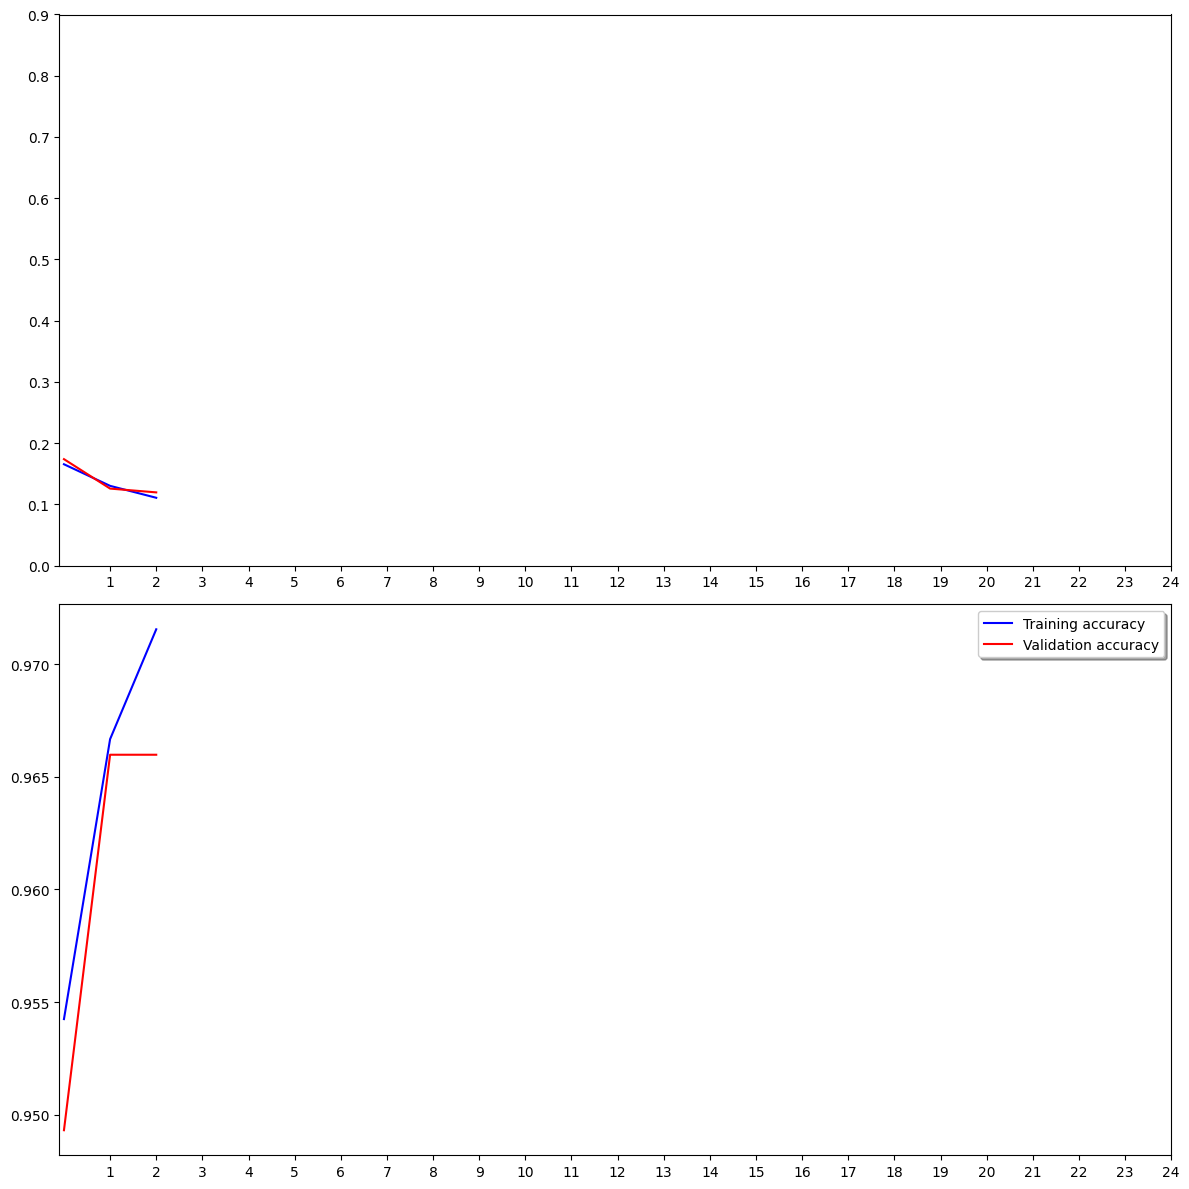

In [21]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(model_history.history['loss'], color='b', label="Training loss")
ax1.plot(model_history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 25, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(model_history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(model_history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 25, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()